First we shall import all the libraries that could be used in this task.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import imblearn

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform
from sklearn.metrics import classification_report

In [2]:
#These are all constants that can be varied to see how they affect the model

N_COMPONENTS = 18 #The number of components to use in PCA

MAX_N_NEIGHBORS = 10 #The maximum number of neighbors to use in KNN (varied from 1 to MAX and the best was chosen)
TEST_SIZES = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5] #The test sizes to use in test_train_split (varied from 0.05 to 0.5 and the best was chosen)

CV = 5 #Cross-validation parameter in RandomizedSearchCV
N_ITER = 100 #Number of iterations in RandomizedSearchCV

FINAL_TEST_SIZE = 0.2 #The final test size (in test_train_split)
FINAL_PARAMETERS_KNN = [] #This will be filled during runtime
FINAL_PARAMETERS_SVM = [] #This will be filled during runtime

Next, we will import the dataset

In [3]:
df = pd.read_csv('./kag_risk_factors_cervical_cancer.csv')

Now, we can analyse certain basic characteristics of the dataset

In [4]:
df.shape

(858, 36)

In [5]:
df.columns

Index(['Age', 'Number of sexual partners', 'First sexual intercourse',
       'Num of pregnancies', 'Smokes', 'Smokes (years)', 'Smokes (packs/year)',
       'Hormonal Contraceptives', 'Hormonal Contraceptives (years)', 'IUD',
       'IUD (years)', 'STDs', 'STDs (number)', 'STDs:condylomatosis',
       'STDs:cervical condylomatosis', 'STDs:vaginal condylomatosis',
       'STDs:vulvo-perineal condylomatosis', 'STDs:syphilis',
       'STDs:pelvic inflammatory disease', 'STDs:genital herpes',
       'STDs:molluscum contagiosum', 'STDs:AIDS', 'STDs:HIV',
       'STDs:Hepatitis B', 'STDs:HPV', 'STDs: Number of diagnosis',
       'STDs: Time since first diagnosis', 'STDs: Time since last diagnosis',
       'Dx:Cancer', 'Dx:CIN', 'Dx:HPV', 'Dx', 'Hinselmann', 'Schiller',
       'Citology', 'Biopsy'],
      dtype='object')

In [6]:
df.describe()

,Age,STDs: Number of diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx,Hinselmann,Schiller,Citology,Biopsy
count,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000
mean,26.820513,0.087413,0.020979,0.010490,0.020979,0.027972,0.040793,0.086247,0.051282,0.064103
std,8.497948,0.302545,0.143398,0.101939,0.143398,0.164989,0.197925,0.280892,0.220701,0.245078
min,13.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,32.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,84.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [7]:
df.dtypes

Age                                    int64
Number of sexual partners             object
First sexual intercourse              object
Num of pregnancies                    object
Smokes                                object
Smokes (years)                        object
Smokes (packs/year)                   object
Hormonal Contraceptives               object
Hormonal Contraceptives (years)       object
IUD                                   object
IUD (years)                           object
STDs                                  object
STDs (number)                         object
STDs:condylomatosis                   object
STDs:cervical condylomatosis          object
STDs:vaginal condylomatosis           object
STDs:vulvo-perineal condylomatosis    object
STDs:syphilis                         object
STDs:pelvic inflammatory disease      object
STDs:genital herpes                   object
STDs:molluscum contagiosum            object
STDs:AIDS                             object
STDs:HIV  

We have the basic outline of the dataframe.

In [8]:
df.isna().any()

Age                                   False
Number of sexual partners             False
First sexual intercourse              False
Num of pregnancies                    False
Smokes                                False
Smokes (years)                        False
Smokes (packs/year)                   False
Hormonal Contraceptives               False
Hormonal Contraceptives (years)       False
IUD                                   False
IUD (years)                           False
STDs                                  False
STDs (number)                         False
STDs:condylomatosis                   False
STDs:cervical condylomatosis          False
STDs:vaginal condylomatosis           False
STDs:vulvo-perineal condylomatosis    False
STDs:syphilis                         False
STDs:pelvic inflammatory disease      False
STDs:genital herpes                   False
STDs:molluscum contagiosum            False
STDs:AIDS                             False
STDs:HIV                        

Initially it appears that the dataset doesn't have any null values. However, I viewed the csv and the null values have been given as '?'. So performing the operations for the same gives us:

In [4]:
df = df.replace('?', np.nan)
print(df.isna().sum())

Age                                     0
Number of sexual partners              26
First sexual intercourse                7
Num of pregnancies                     56
Smokes                                 13
Smokes (years)                         13
Smokes (packs/year)                    13
Hormonal Contraceptives               108
Hormonal Contraceptives (years)       108
IUD                                   117
IUD (years)                           117
STDs                                  105
STDs (number)                         105
STDs:condylomatosis                   105
STDs:cervical condylomatosis          105
STDs:vaginal condylomatosis           105
STDs:vulvo-perineal condylomatosis    105
STDs:syphilis                         105
STDs:pelvic inflammatory disease      105
STDs:genital herpes                   105
STDs:molluscum contagiosum            105
STDs:AIDS                             105
STDs:HIV                              105
STDs:Hepatitis B                  

Since there are quite a lot of empty values in a small dataset, it doesn't make sense to take the approach of data elimination to get rid of empty values. We shall proceed with data imputation.

Also, The columns 'STDs: Time since first diagnosis' and 'STDs: Time since last diagnosis' have nearly 90% empty values so it doesn't make sense to impute them as it could lead the model astray.

In [5]:
df.drop(['STDs: Time since first diagnosis', 'STDs: Time since last diagnosis'], axis=1, inplace=True)

In [11]:
print(df.describe(include='all'))

               Age Number of sexual partners First sexual intercourse  \
count   858.000000                       832                      851   
unique         NaN                        12                       21   
top            NaN                       2.0                     15.0   
freq           NaN                       272                      163   
mean     26.820513                       NaN                      NaN   
std       8.497948                       NaN                      NaN   
min      13.000000                       NaN                      NaN   
25%      20.000000                       NaN                      NaN   
50%      25.000000                       NaN                      NaN   
75%      32.000000                       NaN                      NaN   
max      84.000000                       NaN                      NaN   

       Num of pregnancies Smokes Smokes (years) Smokes (packs/year)  \
count                 802    845            845     

In [12]:
# num_partners_median = df['Number of sexual partners'].median() 
# #Number of sexual partners would likely follow a normal distribution but could have outliers so median would be a good fit 
# df['Number of sexual partners'] = df['Number of sexual partners'].fillna(num_partners_median)

In [6]:
imputer = SimpleImputer(strategy='median')
df_imputed = imputer.fit_transform(df)
df_imputed = pd.DataFrame(df_imputed, columns=df.columns)
df = df_imputed

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 858 entries, 0 to 857
Data columns (total 34 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Age                                 858 non-null    float64
 1   Number of sexual partners           858 non-null    float64
 2   First sexual intercourse            858 non-null    float64
 3   Num of pregnancies                  858 non-null    float64
 4   Smokes                              858 non-null    float64
 5   Smokes (years)                      858 non-null    float64
 6   Smokes (packs/year)                 858 non-null    float64
 7   Hormonal Contraceptives             858 non-null    float64
 8   Hormonal Contraceptives (years)     858 non-null    float64
 9   IUD                                 858 non-null    float64
 10  IUD (years)                         858 non-null    float64
 11  STDs                                858 non-n

In [15]:
df.describe(include='all')

,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,...,STDs:HPV,STDs: Number of diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx,Hinselmann,Schiller,Citology,Biopsy
count,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,...,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000
mean,26.820513,2.511655,16.995338,2.257576,0.143357,1.201241,0.446278,0.686480,2.035331,0.096737,...,0.002331,0.087413,0.020979,0.010490,0.020979,0.027972,0.040793,0.086247,0.051282,0.064103
std,8.497948,1.644759,2.791883,1.400981,0.350641,4.060623,2.210351,0.464194,3.567040,0.295771,...,0.048252,0.302545,0.143398,0.101939,0.143398,0.164989,0.197925,0.280892,0.220701,0.245078
min,13.000000,1.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,20.000000,2.000000,15.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,25.000000,2.000000,17.000000,2.000000,0.000000,0.000000,0.000000,1.000000,0.500000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,32.000000,3.000000,18.000000,3.000000,0.000000,0.000000,0.000000,1.000000,2.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,84.000000,28.000000,32.000000,11.000000,1.000000,37.000000,37.000000,1.000000,30.000000,1.000000,...,1.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Now I'll divide the dataset into X (features) and Y (targets) and then perform operations upon them individually.

In [7]:
X = df.iloc[:,:30]
Y = df.iloc[:,30:]

print(X.columns)
print(Y.columns)

Index(['Age', 'Number of sexual partners', 'First sexual intercourse',
       'Num of pregnancies', 'Smokes', 'Smokes (years)', 'Smokes (packs/year)',
       'Hormonal Contraceptives', 'Hormonal Contraceptives (years)', 'IUD',
       'IUD (years)', 'STDs', 'STDs (number)', 'STDs:condylomatosis',
       'STDs:cervical condylomatosis', 'STDs:vaginal condylomatosis',
       'STDs:vulvo-perineal condylomatosis', 'STDs:syphilis',
       'STDs:pelvic inflammatory disease', 'STDs:genital herpes',
       'STDs:molluscum contagiosum', 'STDs:AIDS', 'STDs:HIV',
       'STDs:Hepatitis B', 'STDs:HPV', 'STDs: Number of diagnosis',
       'Dx:Cancer', 'Dx:CIN', 'Dx:HPV', 'Dx'],
      dtype='object')
Index(['Hinselmann', 'Schiller', 'Citology', 'Biopsy'], dtype='object')


As it can be seen, there are many correlated parameters (3 related to smoking, 2 related to contraceptives, many related to STDs). We can clearly reduce the number of columns and replace them by the most appropriate parameter and drop the individual ones. I tried to do this manually however the accuracy dropped. Thus I will rely upon PCA to reduce it for me.

In [17]:
# X['Total Smokes'] = X['Smokes'] * (X['Smokes (years)'] * X['Smokes (packs/year)'])
# X.drop(['Smokes', 'Smokes (years)', 'Smokes (packs/year)'], axis=1, inplace=True)

In [18]:
# X.drop(['IUD', 'Hormonal Contraceptives', 'STDs'], axis=1, inplace=True)

In [19]:
print(X.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 858 entries, 0 to 857
Data columns (total 30 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Age                                 858 non-null    float64
 1   Number of sexual partners           858 non-null    float64
 2   First sexual intercourse            858 non-null    float64
 3   Num of pregnancies                  858 non-null    float64
 4   Smokes                              858 non-null    float64
 5   Smokes (years)                      858 non-null    float64
 6   Smokes (packs/year)                 858 non-null    float64
 7   Hormonal Contraceptives             858 non-null    float64
 8   Hormonal Contraceptives (years)     858 non-null    float64
 9   IUD                                 858 non-null    float64
 10  IUD (years)                         858 non-null    float64
 11  STDs                                858 non-n

Now we will try to identify outliers in the data.

In [9]:
z_scores = (X - X.mean()) / X.std()

threshold = 3
outliers = np.abs(z_scores) > threshold

print(outliers.sum())

Age                                    5
Number of sexual partners              8
First sexual intercourse              22
Num of pregnancies                    10
Smokes                                 0
Smokes (years)                        27
Smokes (packs/year)                   14
Hormonal Contraceptives                0
Hormonal Contraceptives (years)       21
IUD                                   83
IUD (years)                           28
STDs                                  79
STDs (number)                         45
STDs:condylomatosis                   44
STDs:cervical condylomatosis           0
STDs:vaginal condylomatosis            4
STDs:vulvo-perineal condylomatosis    43
STDs:syphilis                         18
STDs:pelvic inflammatory disease       1
STDs:genital herpes                    1
STDs:molluscum contagiosum             1
STDs:AIDS                              0
STDs:HIV                              18
STDs:Hepatitis B                       1
STDs:HPV        

I couldn't draw large insights from this as the columns with higher number of outliers didn't strike immediately as out of ordinary. However, I played around with the data more.

In [21]:
X.describe(include='all')

,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,...,STDs:molluscum contagiosum,STDs:AIDS,STDs:HIV,STDs:Hepatitis B,STDs:HPV,STDs: Number of diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx
count,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,...,858.000000,858.0,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000
mean,26.820513,2.511655,16.995338,2.257576,0.143357,1.201241,0.446278,0.686480,2.035331,0.096737,...,0.001166,0.0,0.020979,0.001166,0.002331,0.087413,0.020979,0.010490,0.020979,0.027972
std,8.497948,1.644759,2.791883,1.400981,0.350641,4.060623,2.210351,0.464194,3.567040,0.295771,...,0.034139,0.0,0.143398,0.034139,0.048252,0.302545,0.143398,0.101939,0.143398,0.164989
min,13.000000,1.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,20.000000,2.000000,15.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,25.000000,2.000000,17.000000,2.000000,0.000000,0.000000,0.000000,1.000000,0.500000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,32.000000,3.000000,18.000000,3.000000,0.000000,0.000000,0.000000,1.000000,2.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,84.000000,28.000000,32.000000,11.000000,1.000000,37.000000,37.000000,1.000000,30.000000,1.000000,...,1.000000,0.0,1.000000,1.000000,1.000000,3.000000,1.000000,1.000000,1.000000,1.000000


In [8]:
X[X['Number of sexual partners'] == 28]

,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,...,STDs:molluscum contagiosum,STDs:AIDS,STDs:HIV,STDs:Hepatitis B,STDs:HPV,STDs: Number of diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx
467,16.0,28.0,10.0,1.0,1.0,5.0,5.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


This seems quite unlikely since having 28 sexual partners at the age of 16 is definitely an outlier case. So we can drop this entry.

In [8]:
X = X.drop(index=467)
Y = Y.drop(index=467)

In [24]:
print(X.describe(include='all', percentiles=[0.01, 0.02, 0.03, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.97, 0.98, 0.99]))

              Age  Number of sexual partners  First sexual intercourse  \
count  857.000000                 857.000000                857.000000   
mean    26.833139                   2.481914                 17.003501   
std      8.494854                   1.395909                  2.783250   
min     13.000000                   1.000000                 10.000000   
1%      15.000000                   1.000000                 12.560000   
2%      15.000000                   1.000000                 13.000000   
3%      15.000000                   1.000000                 13.000000   
5%      16.000000                   1.000000                 14.000000   
10%     18.000000                   1.000000                 14.000000   
25%     20.000000                   2.000000                 15.000000   
50%     25.000000                   2.000000                 17.000000   
75%     32.000000                   3.000000                 18.000000   
90%     37.000000                   4.

Looking at the 'Age' parameter, we see that the 90th %ile to 95%ile is slightly gradual but it rapidly increases after that. Also, the ages less than 16 can also be dropped due to similar reasons.
We can also extend this idea to Num of sexual partners > 7 (99th %ile)

In [9]:
a = (X['Age'] <= X['Age'].quantile(0.05)) | (X['Age'] >= X['Age'].quantile(0.95))
b = (X['Number of sexual partners'] > X['Number of sexual partners'].quantile(0.99))

Y = Y.drop(X[a | b].index)
X = X.drop(X[a | b].index)

The following features have very obvious outliers by the following reasoning:
The value of the feature is quite close to the mean upto some %ile but the max value is quite higher.

The features are:
1. First Sexual Intercourse (above 99th %ile)
2. Num of Pregnancies (above 99th %ile)
3. Hormonal Contraceptives (above 97th %ile)
4. IUD (above 99th %ile)
5. Smokes (above 98th %ile)

In [10]:
a = (X['First sexual intercourse'] > X['First sexual intercourse'].quantile(0.99)) | (X['First sexual intercourse'] < X['First sexual intercourse'].quantile(0.01))
b = X['Num of pregnancies'] > X['Num of pregnancies'].quantile(0.99)
c = X['Hormonal Contraceptives (years)'] > X['Hormonal Contraceptives (years)'].quantile(0.97)
d = X['IUD (years)'] > X['IUD (years)'].quantile(0.99)
e = X['Smokes (packs/year)'] > X['Smokes (packs/year)'].quantile(0.98)

Y = Y.drop(X[a | b | c | d | e].index)
X = X.drop(X[a | b | c | d | e].index)

Now all the obvious outliers have been removed. We can proceed to normalize the data after which we will use PCA to reduce the dimensionality.

In [11]:
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)
X_normalized = pd.DataFrame(X_normalized, columns= X.columns)

In [16]:
X_normalized.describe(include='all')

,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,...,STDs:molluscum contagiosum,STDs:AIDS,STDs:HIV,STDs:Hepatitis B,STDs:HPV,STDs: Number of diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx
count,6.910000e+02,6.910000e+02,6.910000e+02,6.910000e+02,6.910000e+02,6.910000e+02,6.910000e+02,6.910000e+02,6.910000e+02,6.910000e+02,...,6.910000e+02,691.0,691.000000,691.0,6.910000e+02,6.910000e+02,6.910000e+02,6.910000e+02,6.910000e+02,691.000000
mean,-1.233938e-16,-5.141409e-18,-3.650400e-16,4.113127e-17,1.542423e-17,1.028282e-17,3.984592e-17,1.542423e-16,1.131110e-16,-3.084845e-17,...,-7.712114e-18,0.0,0.000000,0.0,2.056564e-17,-2.185099e-17,2.056564e-17,6.683832e-17,1.542423e-17,0.000000
std,1.000724e+00,1.000724e+00,1.000724e+00,1.000724e+00,1.000724e+00,1.000724e+00,1.000724e+00,1.000724e+00,1.000724e+00,1.000724e+00,...,1.000724e+00,0.0,1.000724,0.0,1.000724e+00,1.000724e+00,1.000724e+00,1.000724e+00,1.000724e+00,1.000724
min,-1.437863e+00,-1.151579e+00,-1.690581e+00,-1.798016e+00,-3.720020e-01,-2.827867e-01,-2.584950e-01,-1.534395e+00,-6.748773e-01,-2.852668e-01,...,-3.806935e-02,0.0,-0.153960,0.0,-5.387725e-02,-2.922372e-01,-1.384704e-01,-1.011628e-01,-1.384704e-01,-0.172645
25%,-7.749348e-01,-3.494208e-01,-8.546660e-01,-9.652887e-01,-3.720020e-01,-2.827867e-01,-2.584950e-01,-1.534395e+00,-6.748773e-01,-2.852668e-01,...,-3.806935e-02,0.0,-0.153960,0.0,-5.387725e-02,-2.922372e-01,-1.384704e-01,-1.011628e-01,-1.384704e-01,-0.172645
50%,-1.120070e-01,-3.494208e-01,-1.875063e-02,-1.325615e-01,-3.720020e-01,-2.827867e-01,-2.584950e-01,6.517225e-01,-4.705419e-01,-2.852668e-01,...,-3.806935e-02,0.0,-0.153960,0.0,-5.387725e-02,-2.922372e-01,-1.384704e-01,-1.011628e-01,-1.384704e-01,-0.172645
75%,7.166528e-01,4.527379e-01,3.992071e-01,7.001657e-01,-3.720020e-01,-2.827867e-01,-2.584950e-01,6.517225e-01,1.424644e-01,-2.852668e-01,...,-3.806935e-02,0.0,-0.153960,0.0,-5.387725e-02,-2.922372e-01,-1.384704e-01,-1.011628e-01,-1.384704e-01,-0.172645
max,2.373972e+00,3.661373e+00,4.160826e+00,3.198347e+00,2.688157e+00,7.907765e+00,7.613432e+00,6.517225e-01,3.411831e+00,3.505490e+00,...,2.626785e+01,0.0,6.495191,0.0,1.856071e+01,9.323759e+00,7.221762e+00,9.885054e+00,7.221762e+00,5.792236


In [12]:
X_normalized_copy = X_normalized

parameter = 30

pca = PCA(n_components= parameter)
pca.fit(X_normalized_copy)
X_reduced = pca.transform(X_normalized_copy)
X_reduced = pd.DataFrame(X_reduced)

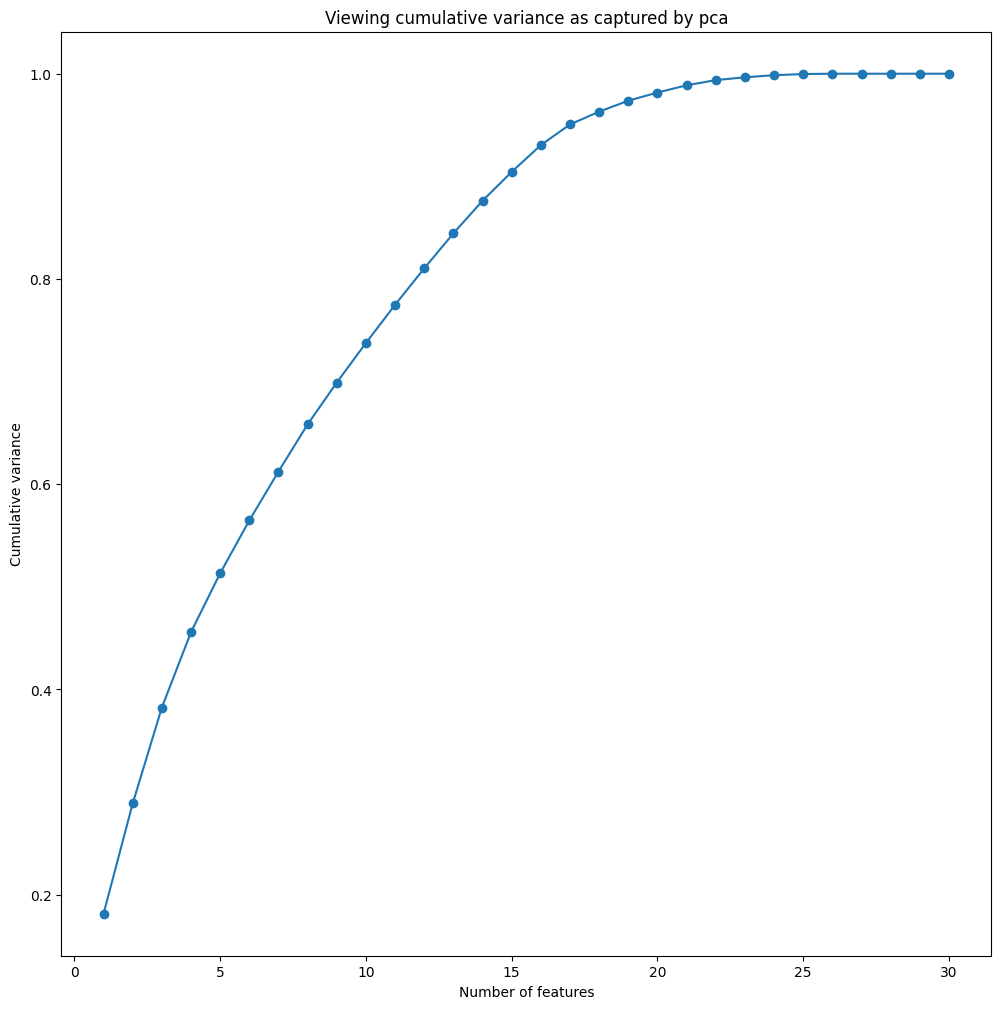

In [13]:
cumulative_variance = pca.explained_variance_ratio_.cumsum()
plt.figure(figsize=(12,12))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.title("Viewing cumulative variance as captured by pca")
plt.xlabel("Number of features")
plt.ylabel("Cumulative variance")
plt.show()

As can be seen, the cumulative variance explained by the pca model stagnates after n_components ~ 18. So, we will reduce our dimensionality from 25 to 18 to reduce the computational requirement whilst retaining most of the variance of the data.

In [14]:
#Final reduced dataset
X_normalized_copy = X_normalized
pca = PCA(n_components = N_COMPONENTS)
pca.fit(X_normalized_copy)
X_reduced = pca.transform(X_normalized_copy)
X_reduced = pd.DataFrame(X_reduced)

In [15]:
test_name_list = Y.columns
balanced_training_data_list = []
balanced_target_data_list = []
print(test_name_list)

Index(['Hinselmann', 'Schiller', 'Citology', 'Biopsy'], dtype='object')


In [16]:
def balance_data(X_reduced, target):
    smote = SMOTE()
    X_balanced, Y_balanced = smote.fit_resample(X_reduced, target)
    print(X_balanced.shape, Y_balanced.shape)
    return X_balanced, Y_balanced

In [17]:
for i in range (len(test_name_list)):
    X_temp, Y_temp = balance_data(X_reduced, Y[test_name_list[i]])
    balanced_training_data_list.append(X_temp)
    balanced_target_data_list.append(Y_temp)

(1322, 18) (1322,)
(1272, 18) (1272,)
(1318, 18) (1318,)
(1296, 18) (1296,)


Hinselmann


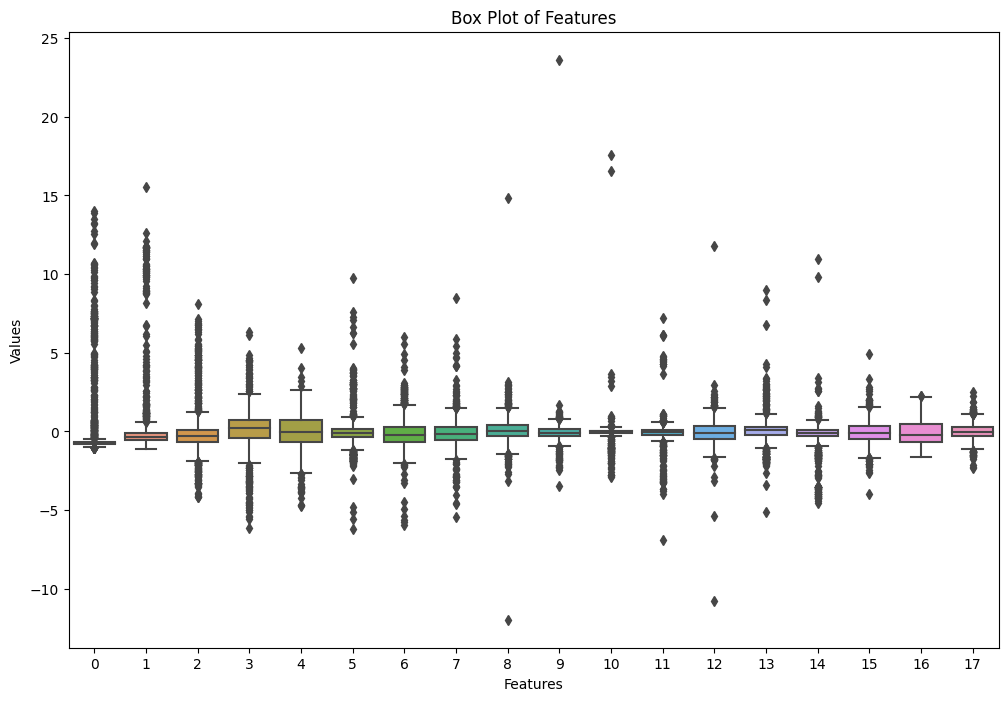

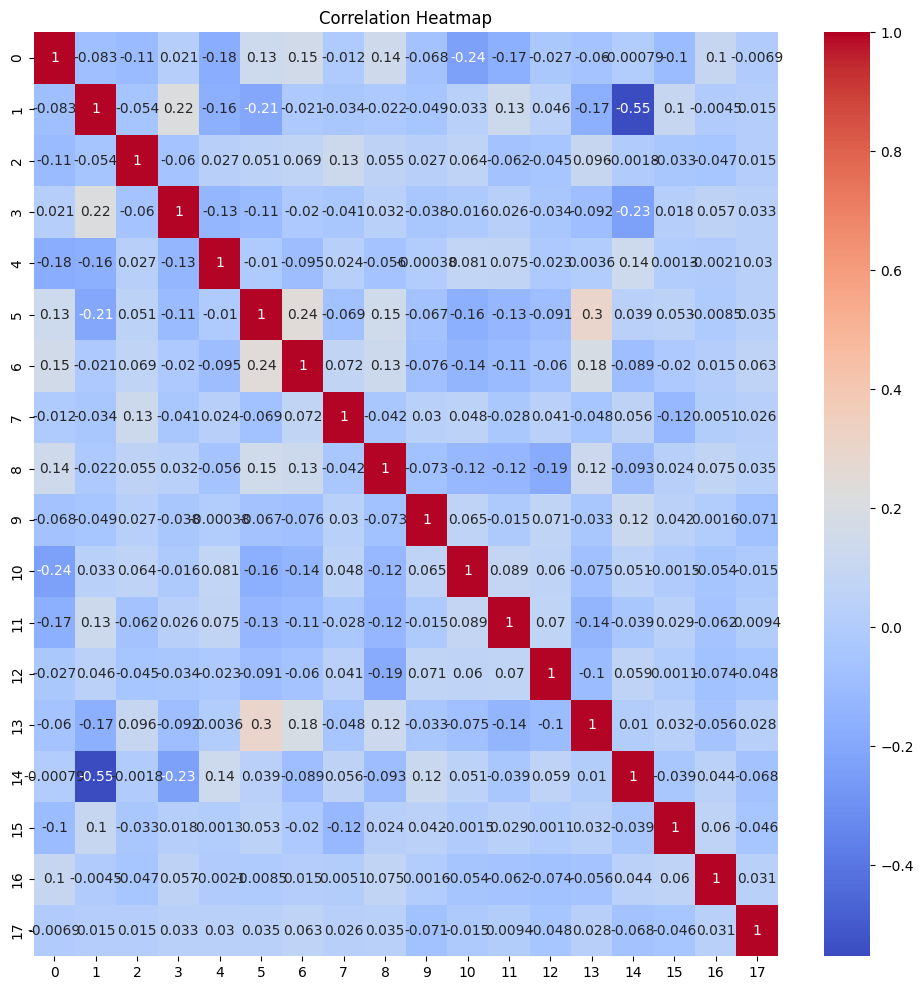





Schiller


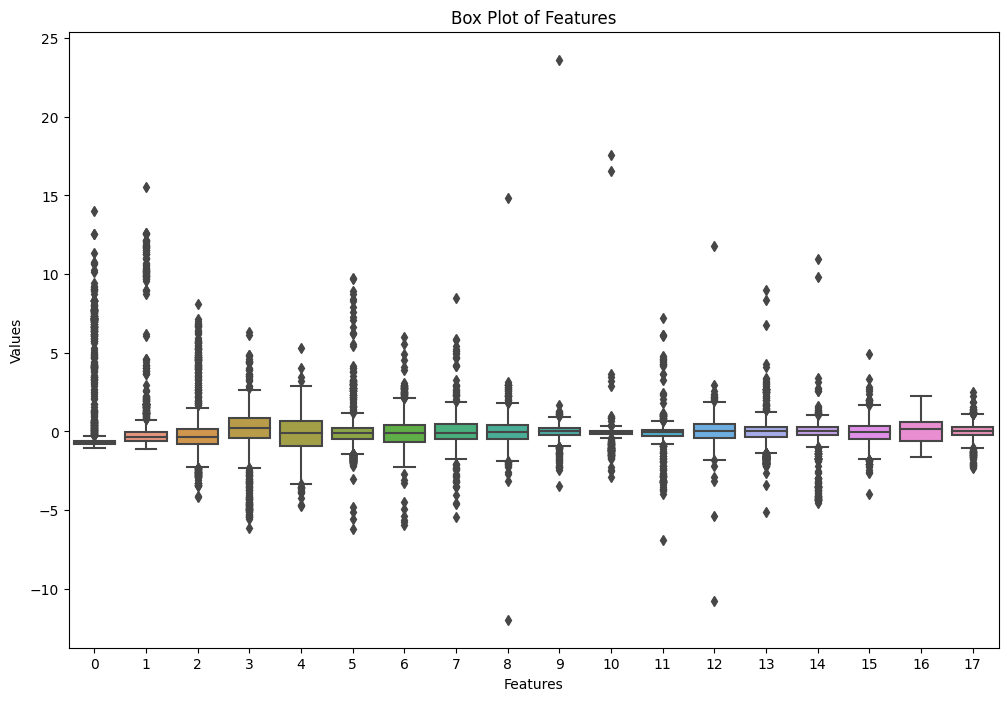

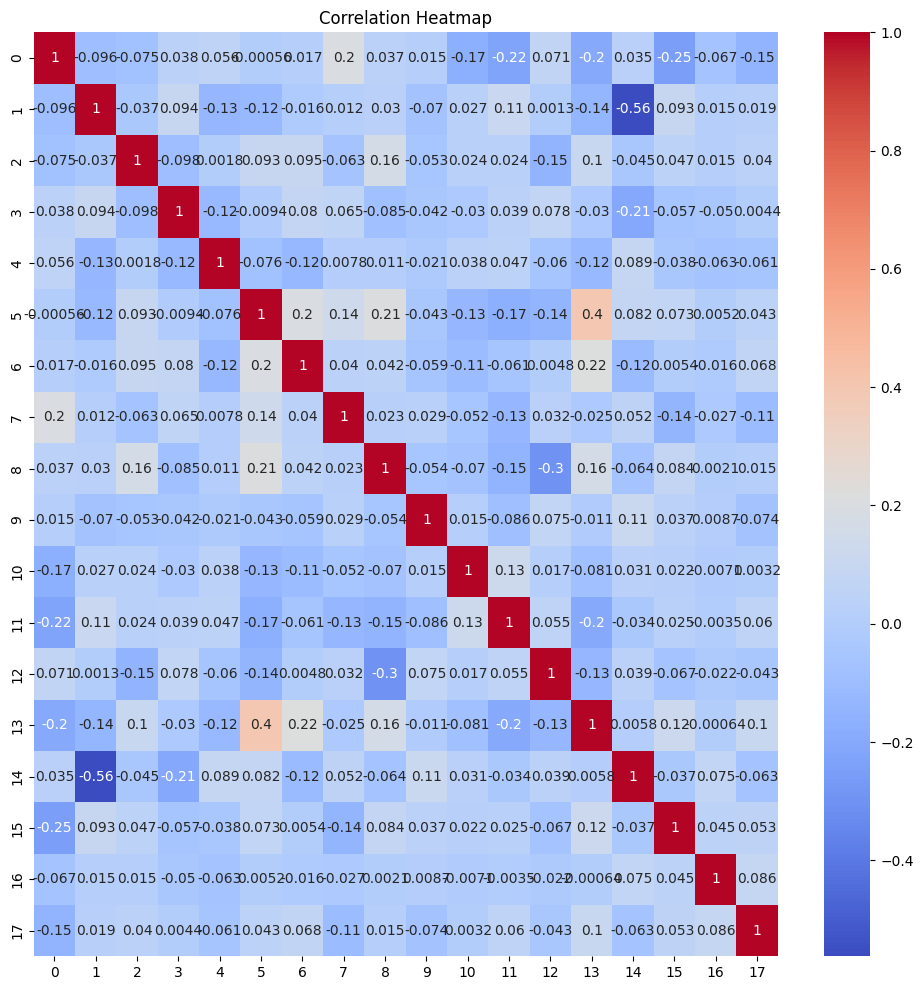





Citology


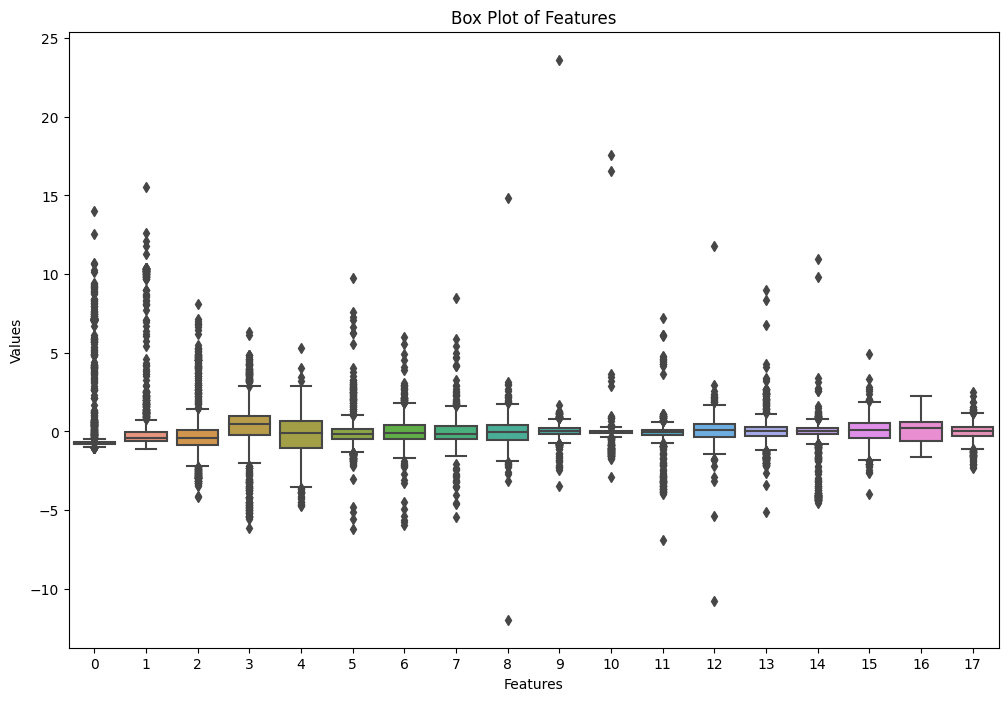

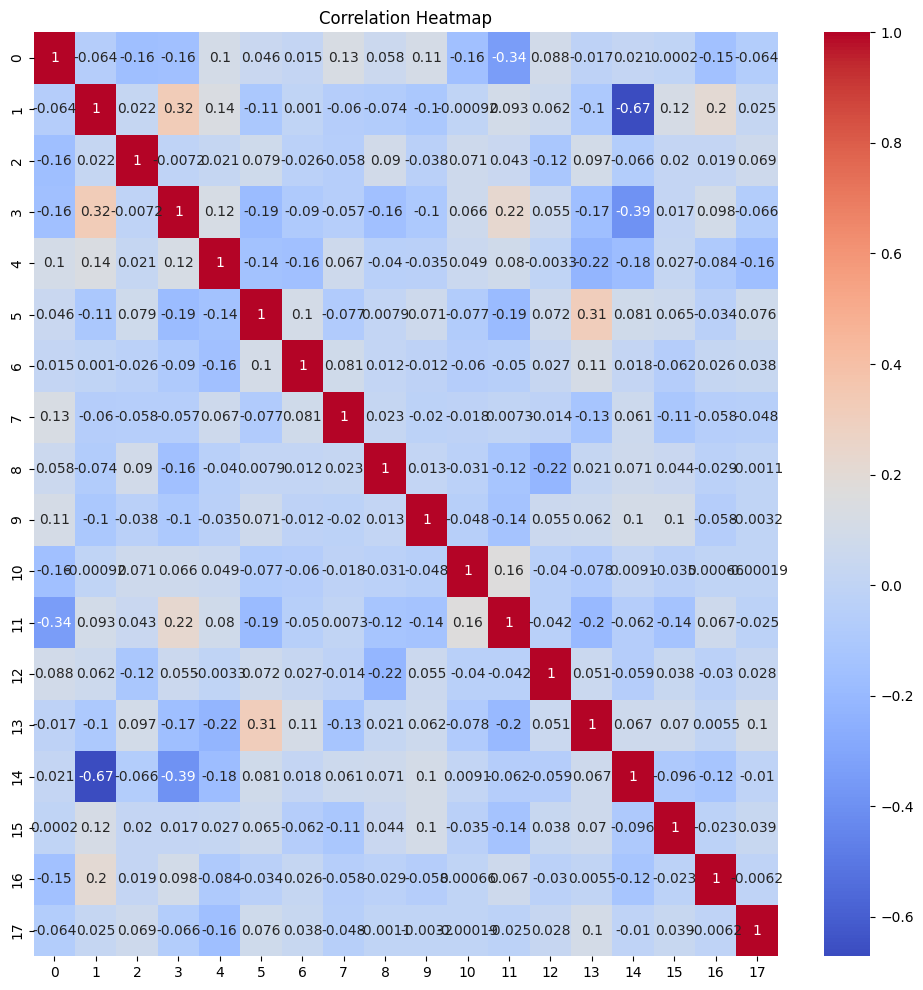





Biopsy


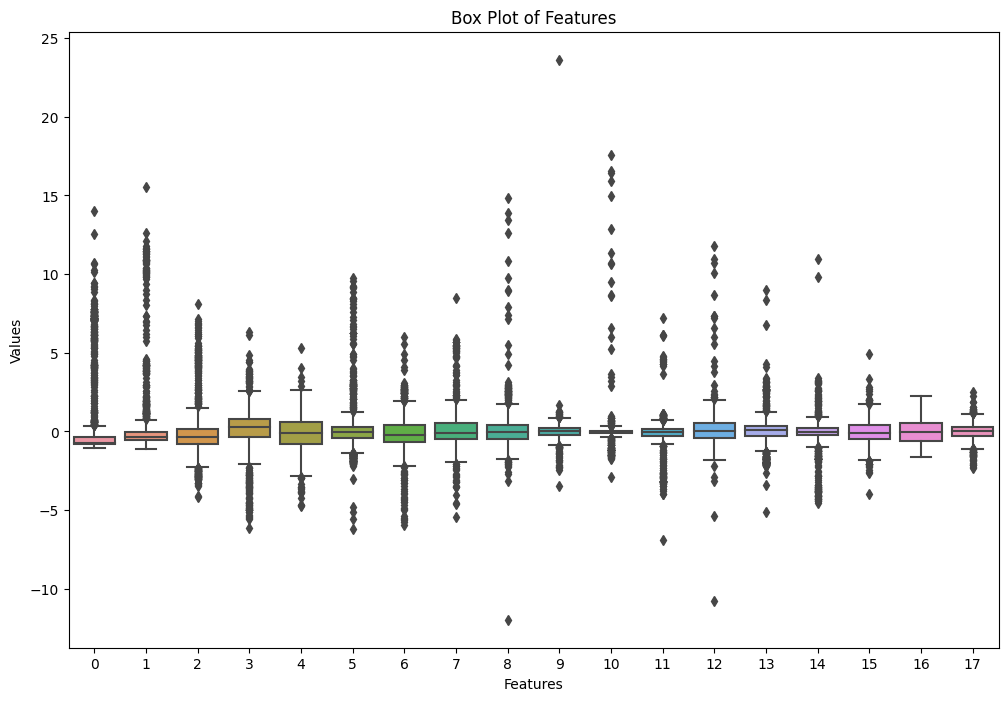

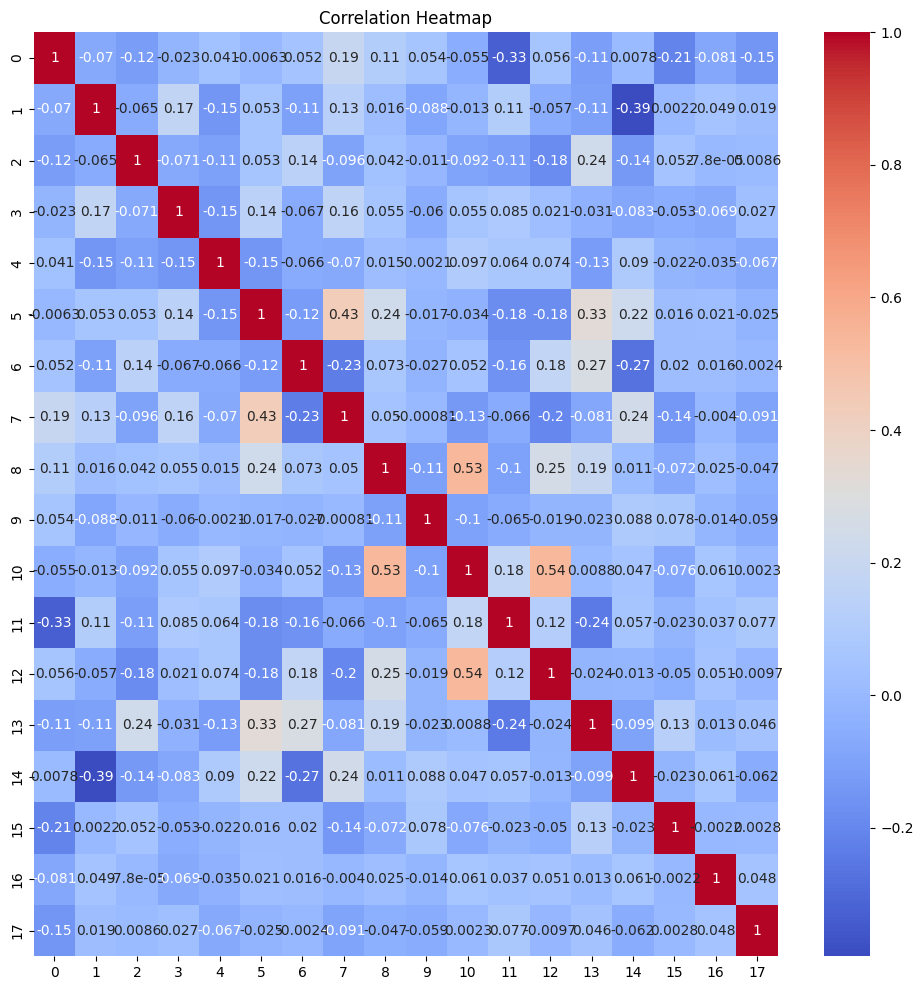

In [17]:
for i in range (len(test_name_list)):
    print("\033[1m" + "\033[36m" + "\033[14m" + test_name_list[i] + "\033[0m") #Printing the heading

    #Boxplot
    plt.figure(figsize=(12, 8))
    sns.boxplot(data=balanced_training_data_list[i])
    plt.title('Box Plot of Features')
    plt.xlabel('Features')
    plt.ylabel('Values')
    plt.show()

    #Correlation Heatmap
    plt.figure(figsize=(12, 12))
    corr_matrix = balanced_training_data_list[i].corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
    plt.title('Correlation Heatmap')
    plt.show()

    print("\n\n\n")

The boxplot lets us view the variation of the features. There is not much variation in the distribution of different features except for a couple of outliers (perhaps the PCA equivalents for features that vary more like age).

As can be seen, no two features are strongly correlated. The minimization done by PCA is quite strict and any more minimization would lead to loss of accuracy.

We will now tune the hyperparameters for KNN.

(1064, 18) (1064,)
Hinselmann
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/siddhant/.local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 72 is smaller than n_iter=100. Running 72 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best parameters found:  {'weights': 'uniform', 'n_neighbors': 2, 'metric': 'manhattan'}
              precision    recall  f1-score   support

         0.0       0.94      0.94      0.94       129
         1.0       0.20      0.20      0.20        10

    accuracy                           0.88       139
   macro avg       0.57      0.57      0.57       139
weighted avg       0.88      0.88      0.88       139



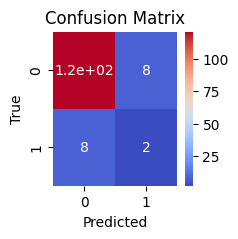

(1020, 18) (1020,)
Schiller
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/siddhant/.local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 72 is smaller than n_iter=100. Running 72 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best parameters found:  {'weights': 'uniform', 'n_neighbors': 2, 'metric': 'manhattan'}
              precision    recall  f1-score   support

         0.0       0.93      0.91      0.92       126
         1.0       0.31      0.38      0.34        13

    accuracy                           0.86       139
   macro avg       0.62      0.65      0.63       139
weighted avg       0.88      0.86      0.87       139



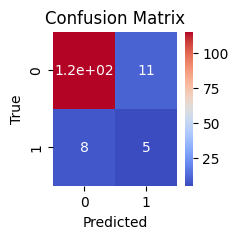

(1048, 18) (1048,)
Citology
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/siddhant/.local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 72 is smaller than n_iter=100. Running 72 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best parameters found:  {'weights': 'uniform', 'n_neighbors': 1, 'metric': 'manhattan'}
              precision    recall  f1-score   support

         0.0       0.97      0.90      0.93       135
         1.0       0.00      0.00      0.00         4

    accuracy                           0.88       139
   macro avg       0.48      0.45      0.47       139
weighted avg       0.94      0.88      0.91       139



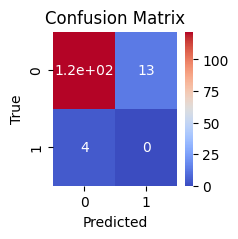

(1036, 18) (1036,)
Biopsy
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/siddhant/.local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 72 is smaller than n_iter=100. Running 72 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best parameters found:  {'weights': 'uniform', 'n_neighbors': 1, 'metric': 'manhattan'}
              precision    recall  f1-score   support

         0.0       0.95      0.90      0.92       130
         1.0       0.19      0.33      0.24         9

    accuracy                           0.86       139
   macro avg       0.57      0.62      0.58       139
weighted avg       0.90      0.86      0.88       139



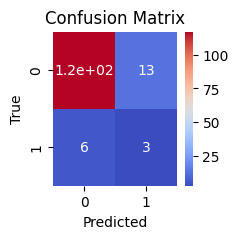

In [19]:
TEST_SIZE_LOCAL = 0.2

for i in range (len(test_name_list)):
    X_train, X_test, y_train, y_test = train_test_split(X_reduced, Y[test_name_list[i]], test_size=TEST_SIZE_LOCAL, random_state=42)
    X_train, y_train = balance_data(X_train, y_train)
    
    print("\033[1m" + "\033[36m" + "\033[14m" + test_name_list[i] + "\033[0m") #Printing the heading
    param_random = {'n_neighbors': np.arange(1, MAX_N_NEIGHBORS),
                    'weights': ['uniform', 'distance'],
                    'metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski']}
    random_search = RandomizedSearchCV(KNeighborsClassifier(), param_random, cv=CV, n_iter=N_ITER, n_jobs=-1, verbose=1)

    random_search.fit(X_train, y_train)
    print("Best parameters found: ", random_search.best_params_)
    FINAL_PARAMETERS_KNN.append(random_search.best_params_)
    
    best_estimator = random_search.best_estimator_
    y_pred = best_estimator.predict(X_test)
    print(classification_report(y_test, y_pred))
    
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(2,2))
    sns.heatmap(cm, annot=True, cmap='coolwarm')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # for j in range (MAX_N_NEIGHBORS):
    #     print(j + 1)
    #     knn = KNeighborsClassifier(n_neighbors = j + 1)
        
    #     # clf.fit(X_train, y_train)
    #     knn.fit(X_train, y_train)

    #     # y_pred_svm = clf.predict(X_test)
    #     y_pred_knn = knn.predict(X_test)

    #     # accuracy = accuracy_score(y_test, y_pred_svm)
    #     # precision = precision_score(y_test, y_pred_svm, average='weighted')
    #     # recall = recall_score(y_test, y_pred_svm, average='weighted')

    #     # print("SVM")
    #     # print('Accuracy:', accuracy)
    #     # print('Precision:', precision)
    #     # print('Recall:', recall)

    #     # cm = confusion_matrix(y_test, y_pred_svm)

    #     # plt.figure(figsize=(8, 8))
    #     # sns.heatmap(cm, annot=True, cmap='coolwarm')
    #     # plt.title('Confusion Matrix')
    #     # plt.xlabel('Predicted')
    #     # plt.ylabel('True')
    #     # plt.show()

        # accuracy = accuracy_score(y_test, y_pred_knn)
        # precision = precision_score(y_test, y_pred_knn, average='weighted')
        # recall = recall_score(y_test, y_pred_knn, average='weighted')

        # print("KNN")
        # print('Accuracy:', accuracy)
        # print('Precision:', precision)
        # print('Recall:', recall)

As we can see, `n-neighbors = 1` does give the maximum accuracy however can lead to overfitting. As a tradeoff between accuracy and preventing overfitting, the final value of `n-neighbors` will be chosen as 2

We will now tune the hyperparameter for SVM.

(1064, 18) (1064,)
Best parameters found:  {'C': 89964.33407315143, 'gamma': 'auto', 'kernel': 'rbf'}
              precision    recall  f1-score   support

         0.0       0.93      0.91      0.92       129
         1.0       0.08      0.10      0.09        10

    accuracy                           0.86       139
   macro avg       0.51      0.51      0.51       139
weighted avg       0.87      0.86      0.86       139



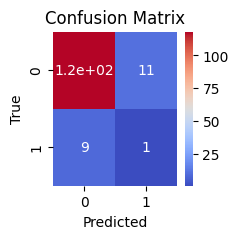

(1020, 18) (1020,)
Best parameters found:  {'C': 0.002447865943978965, 'gamma': 'scale', 'kernel': 'linear'}
              precision    recall  f1-score   support

         0.0       0.94      0.96      0.95       126
         1.0       0.50      0.38      0.43        13

    accuracy                           0.91       139
   macro avg       0.72      0.67      0.69       139
weighted avg       0.90      0.91      0.90       139



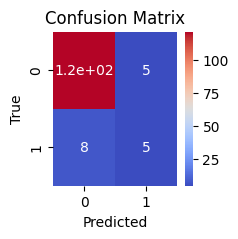

(1048, 18) (1048,)


KeyboardInterrupt: 

In [26]:
for i in range (len(test_name_list)):
    X_train, X_test, y_train, y_test = train_test_split(X_reduced, Y[test_name_list[i]], test_size=0.2, random_state=42)
    X_train, y_train = balance_data(X_train, y_train)

    param_random = {'C': loguniform(1e-4, 1e5),
                    'kernel': ['linear', 'rbf'],
                    'gamma': ['scale', 'auto']}
    random_search = RandomizedSearchCV(SVC(), param_random, n_iter=N_ITER, cv=CV, n_jobs=-1)

    random_search.fit(X_train, y_train)
    print("Best parameters found: ", random_search.best_params_)
    FINAL_PARAMETERS_SVM.append(random_search.best_params_)

    best_estimator = random_search.best_estimator_
    y_pred = best_estimator.predict(X_test)
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(2,2))
    sns.heatmap(cm, annot=True, cmap='coolwarm')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

Hinselmann
0.05
SVM
Accuracy: 0.7910447761194029
Precision: 0.8218550106609808
Recall: 0.7910447761194029


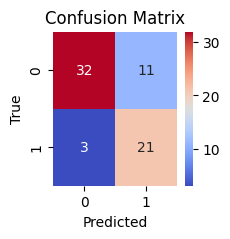

KNN
Accuracy: 0.9402985074626866
Precision: 0.9488272921108741
Recall: 0.9402985074626866


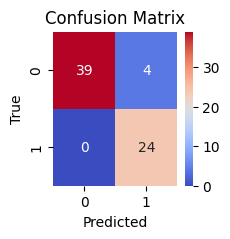

0.1
SVM
Accuracy: 0.8345864661654135
Precision: 0.8506442497015947
Recall: 0.8345864661654135


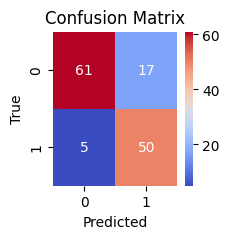

KNN
Accuracy: 0.9699248120300752
Precision: 0.9719638078246464
Recall: 0.9699248120300752


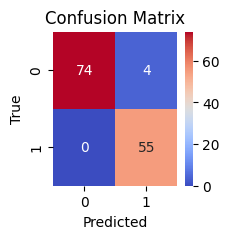

0.15
SVM
Accuracy: 0.8291457286432161
Precision: 0.8389239124917517
Recall: 0.8291457286432161


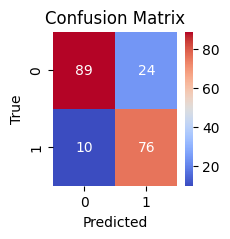

KNN
Accuracy: 0.9698492462311558
Precision: 0.9707815325352552
Recall: 0.9698492462311558


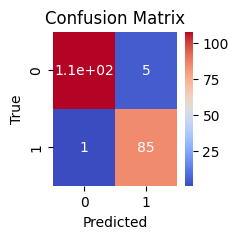

0.2
SVM
Accuracy: 0.8301886792452831
Precision: 0.8391202156334232
Recall: 0.8301886792452831


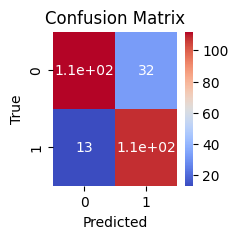

KNN
Accuracy: 0.9509433962264151
Precision: 0.9544048801248404
Recall: 0.9509433962264151


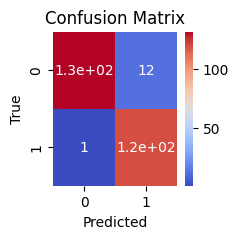

0.25
SVM
Accuracy: 0.797583081570997
Precision: 0.8134987855636941
Recall: 0.797583081570997


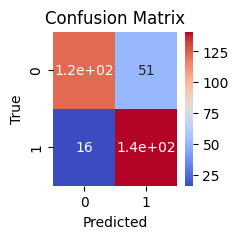

KNN
Accuracy: 0.9425981873111783
Precision: 0.9465071869916974
Recall: 0.9425981873111783


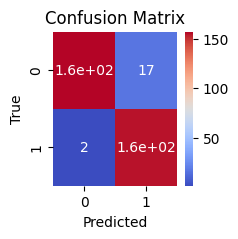

0.3
SVM
Accuracy: 0.8085642317380353
Precision: 0.8251157700218892
Recall: 0.8085642317380353


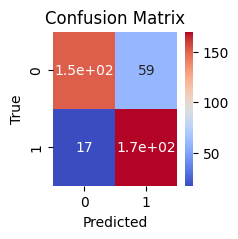

KNN
Accuracy: 0.9420654911838791
Precision: 0.946443174620409
Recall: 0.9420654911838791


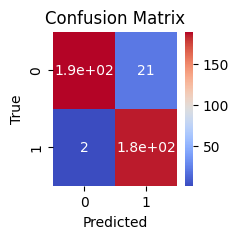

0.35
SVM
Accuracy: 0.7948164146868251
Precision: 0.8083943868643199
Recall: 0.7948164146868251


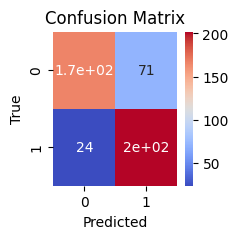

KNN
Accuracy: 0.9481641468682506
Precision: 0.9516291276219089
Recall: 0.9481641468682506


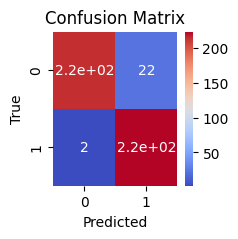

0.4
SVM
Accuracy: 0.7863894139886578
Precision: 0.7949911321633018
Recall: 0.7863894139886578


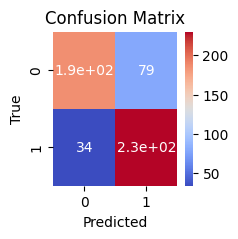

KNN
Accuracy: 0.941398865784499
Precision: 0.9428290342907087
Recall: 0.941398865784499


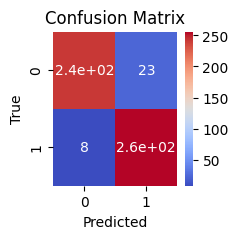

0.45
SVM
Accuracy: 0.7815126050420168
Precision: 0.7955350026323735
Recall: 0.7815126050420168


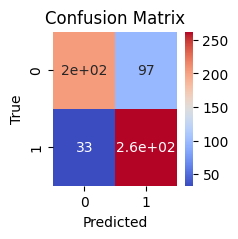

KNN
Accuracy: 0.9159663865546218
Precision: 0.9187449819780713
Recall: 0.9159663865546218


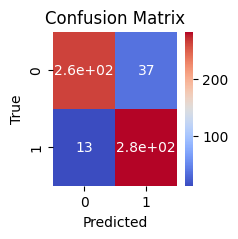

0.5
SVM
Accuracy: 0.7745839636913767
Precision: 0.7848029760347095
Recall: 0.7745839636913767


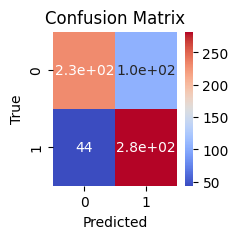

KNN
Accuracy: 0.9107413010590015
Precision: 0.9131928672458661
Recall: 0.9107413010590015


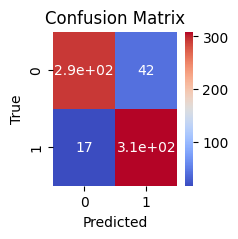

Schiller
0.05
SVM
Accuracy: 0.765625
Precision: 0.7722722722722722
Recall: 0.765625


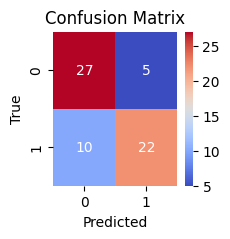

KNN
Accuracy: 0.921875
Precision: 0.9222873900293255
Recall: 0.921875


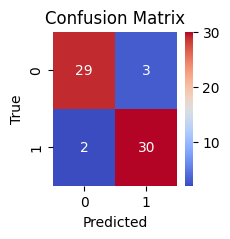

0.1
SVM
Accuracy: 0.703125
Precision: 0.7155363475177304
Recall: 0.703125


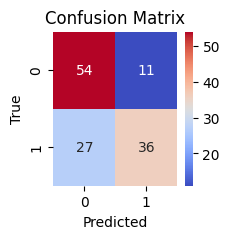

KNN
Accuracy: 0.8984375
Precision: 0.9010033700980392
Recall: 0.8984375


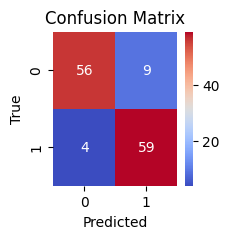

0.15
SVM
Accuracy: 0.7120418848167539
Precision: 0.7265022968731923
Recall: 0.7120418848167539


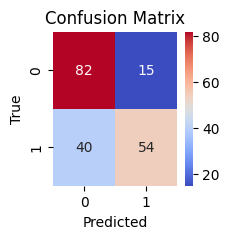

KNN
Accuracy: 0.8691099476439791
Precision: 0.8726034297121574
Recall: 0.8691099476439791


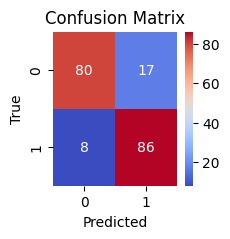

0.2
SVM
Accuracy: 0.7568627450980392
Precision: 0.7636884942656308
Recall: 0.7568627450980392


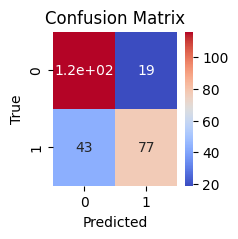

KNN
Accuracy: 0.8627450980392157
Precision: 0.8703124204030245
Recall: 0.8627450980392157


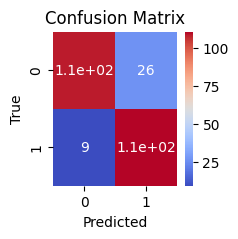

0.25
SVM
Accuracy: 0.7515723270440252
Precision: 0.7607178644663516
Recall: 0.7515723270440252


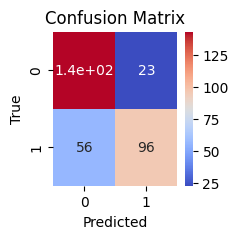

KNN
Accuracy: 0.8773584905660378
Precision: 0.8822689763845608
Recall: 0.8773584905660378


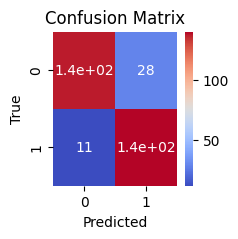

0.3
SVM
Accuracy: 0.7513089005235603
Precision: 0.7655046966430552
Recall: 0.7513089005235603


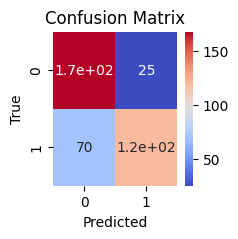

KNN
Accuracy: 0.887434554973822
Precision: 0.8887904896150969
Recall: 0.887434554973822


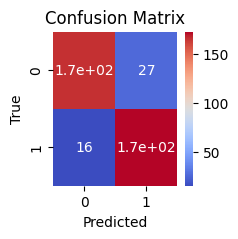

0.35
SVM
Accuracy: 0.7376681614349776
Precision: 0.754102210863647
Recall: 0.7376681614349776


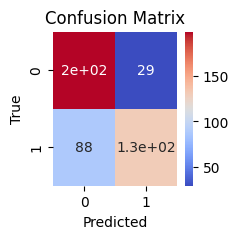

KNN
Accuracy: 0.8968609865470852
Precision: 0.8977631885696056
Recall: 0.8968609865470852


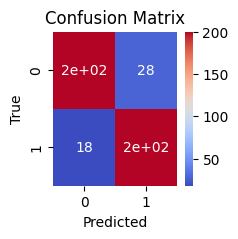

0.4
SVM
Accuracy: 0.7387033398821218
Precision: 0.7532592488951732
Recall: 0.7387033398821218


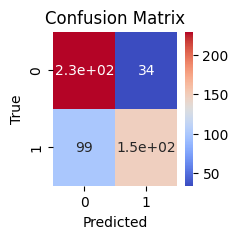

KNN
Accuracy: 0.8919449901768173
Precision: 0.8928332689617884
Recall: 0.8919449901768173


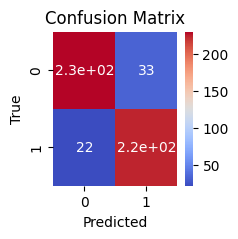

0.45
SVM
Accuracy: 0.7260034904013961
Precision: 0.7375857103348306
Recall: 0.7260034904013961


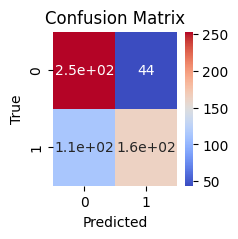

KNN
Accuracy: 0.8795811518324608
Precision: 0.8808530161271244
Recall: 0.8795811518324608


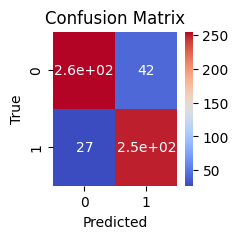

0.5
SVM
Accuracy: 0.7216981132075472
Precision: 0.7336644936452006
Recall: 0.7216981132075472


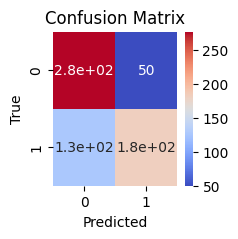

KNN
Accuracy: 0.8773584905660378
Precision: 0.8801729146532117
Recall: 0.8773584905660378


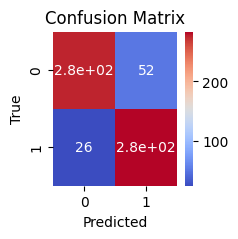

Citology
0.05
SVM
Accuracy: 0.8181818181818182
Precision: 0.8181818181818182
Recall: 0.8181818181818182


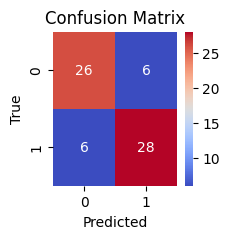

KNN
Accuracy: 0.9393939393939394
Precision: 0.9409090909090908
Recall: 0.9393939393939394


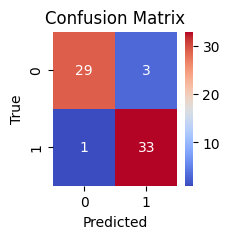

0.1
SVM
Accuracy: 0.7803030303030303
Precision: 0.7803169563279857
Recall: 0.7803030303030303


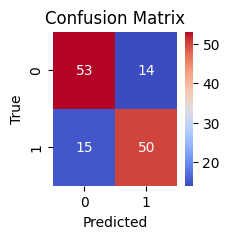

KNN
Accuracy: 0.9090909090909091
Precision: 0.9105182510862493
Recall: 0.9090909090909091


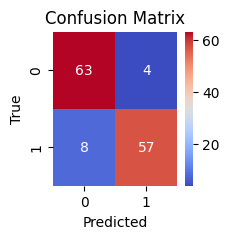

0.15
SVM
Accuracy: 0.7929292929292929
Precision: 0.7932566404788628
Recall: 0.7929292929292929


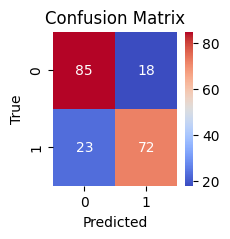

KNN
Accuracy: 0.9141414141414141
Precision: 0.9173032232625256
Recall: 0.9141414141414141


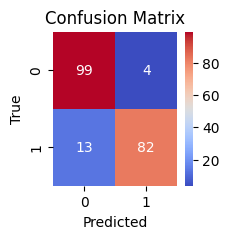

0.2
SVM
Accuracy: 0.8068181818181818
Precision: 0.8093239421868453
Recall: 0.8068181818181818


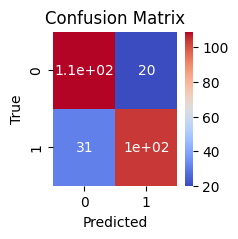

KNN
Accuracy: 0.9090909090909091
Precision: 0.9126763221210549
Recall: 0.9090909090909091


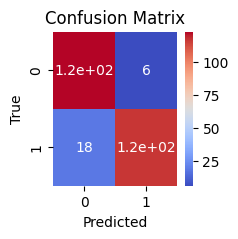

0.25
SVM
Accuracy: 0.7787878787878788
Precision: 0.7801212121212121
Recall: 0.7787878787878788


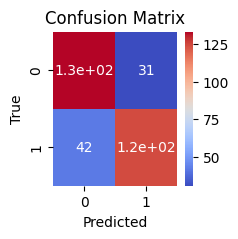

KNN
Accuracy: 0.896969696969697
Precision: 0.8970355924807879
Recall: 0.896969696969697


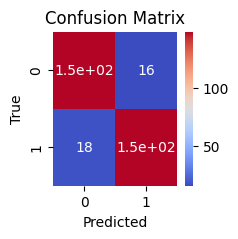

0.3
SVM
Accuracy: 0.7878787878787878
Precision: 0.7879314147734529
Recall: 0.7878787878787878


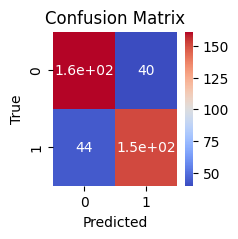

KNN
Accuracy: 0.8863636363636364
Precision: 0.8869076340623753
Recall: 0.8863636363636364


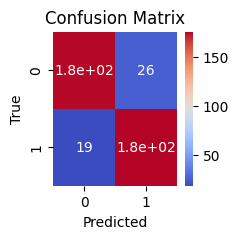

0.35
SVM
Accuracy: 0.7640692640692641
Precision: 0.7676095262302159
Recall: 0.7640692640692641


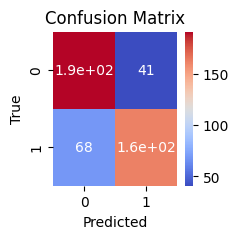

KNN
Accuracy: 0.8896103896103896
Precision: 0.8902211547200946
Recall: 0.8896103896103896


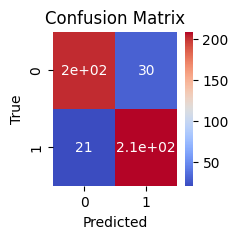

0.4
SVM
Accuracy: 0.7234848484848485
Precision: 0.7313112716208868
Recall: 0.7234848484848485


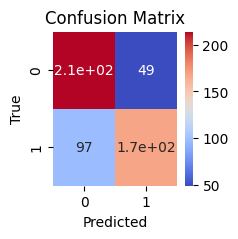

KNN
Accuracy: 0.8920454545454546
Precision: 0.8923104842078877
Recall: 0.8920454545454546


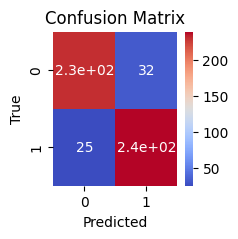

0.45
SVM
Accuracy: 0.7289562289562289
Precision: 0.7342689109580055
Recall: 0.7289562289562289


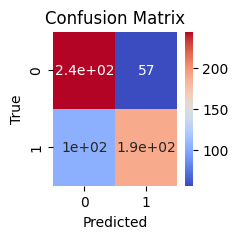

KNN
Accuracy: 0.8888888888888888
Precision: 0.8904113912464952
Recall: 0.8888888888888888


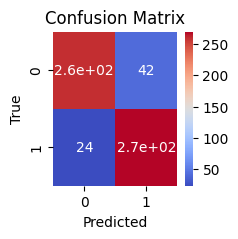

0.5
SVM
Accuracy: 0.716236722306525
Precision: 0.7186495116373507
Recall: 0.716236722306525


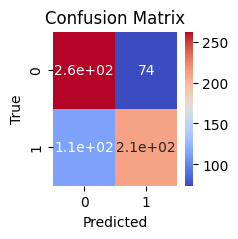

KNN
Accuracy: 0.881638846737481
Precision: 0.8850323125204979
Recall: 0.881638846737481


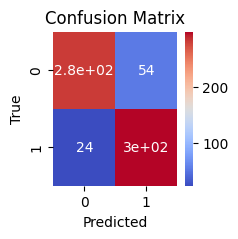

Biopsy
0.05
SVM
Accuracy: 0.8307692307692308
Precision: 0.8310027733177638
Recall: 0.8307692307692308


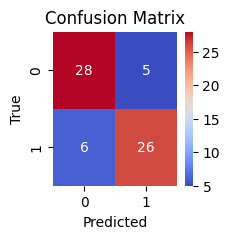

KNN
Accuracy: 0.9384615384615385
Precision: 0.9452991452991453
Recall: 0.9384615384615385


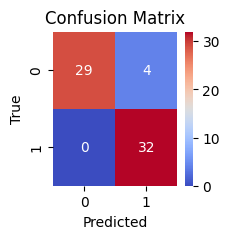

0.1
SVM
Accuracy: 0.8615384615384616
Precision: 0.8616192592320546
Recall: 0.8615384615384616


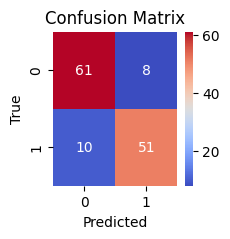

KNN
Accuracy: 0.9307692307692308
Precision: 0.9362355860458328
Recall: 0.9307692307692308


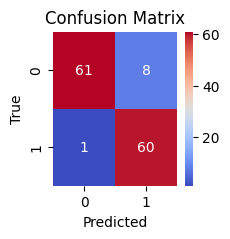

0.15
SVM
Accuracy: 0.8205128205128205
Precision: 0.8326842648876547
Recall: 0.8205128205128205


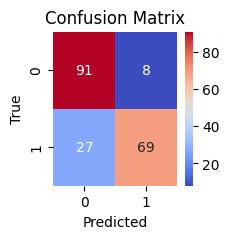

KNN
Accuracy: 0.9384615384615385
Precision: 0.9401839147569698
Recall: 0.9384615384615385


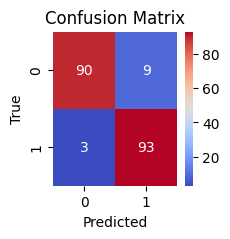

0.2
SVM
Accuracy: 0.75
Precision: 0.7681159420289855
Recall: 0.75


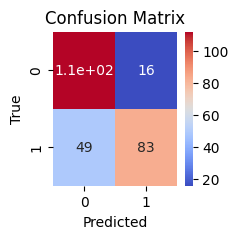

KNN
Accuracy: 0.9346153846153846
Precision: 0.9358271551862135
Recall: 0.9346153846153846


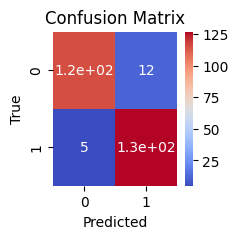

0.25
SVM
Accuracy: 0.7469135802469136
Precision: 0.7519686017338598
Recall: 0.7469135802469136


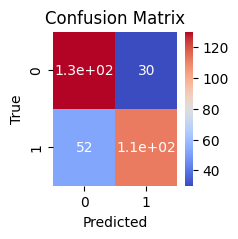

KNN
Accuracy: 0.9290123456790124
Precision: 0.930293677157871
Recall: 0.9290123456790124


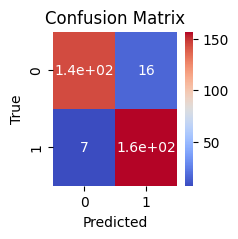

0.3
SVM
Accuracy: 0.7223650385604113
Precision: 0.7269694823653496
Recall: 0.7223650385604113


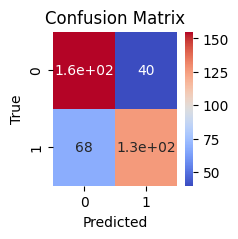

KNN
Accuracy: 0.9177377892030848
Precision: 0.918454267927927
Recall: 0.9177377892030848


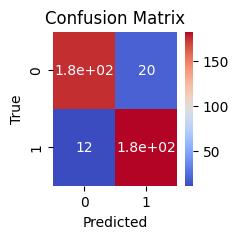

0.35
SVM
Accuracy: 0.7180616740088106
Precision: 0.723733718787051
Recall: 0.7180616740088106


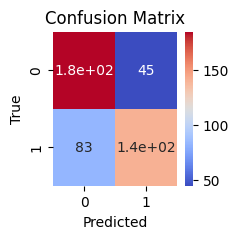

KNN
Accuracy: 0.9140969162995595
Precision: 0.9145258315958225
Recall: 0.9140969162995595


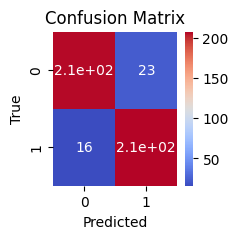

0.4
SVM
Accuracy: 0.7283236994219653
Precision: 0.7336594521453379
Recall: 0.7283236994219653


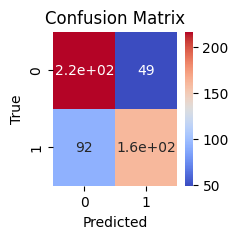

KNN
Accuracy: 0.9210019267822736
Precision: 0.9218425327741886
Recall: 0.9210019267822736


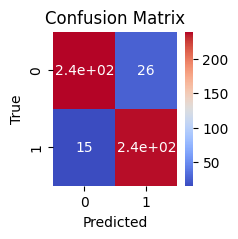

0.45
SVM
Accuracy: 0.7174657534246576
Precision: 0.7309104017827883
Recall: 0.7174657534246576


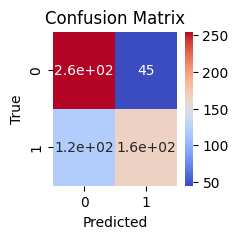

KNN
Accuracy: 0.9178082191780822
Precision: 0.9188770685047231
Recall: 0.9178082191780822


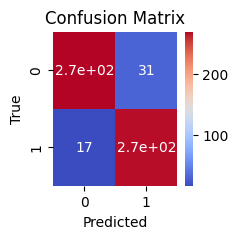

0.5
SVM
Accuracy: 0.720679012345679
Precision: 0.7356948059285305
Recall: 0.720679012345679


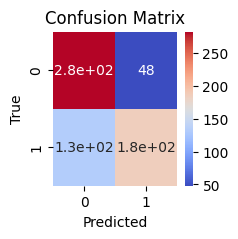

KNN
Accuracy: 0.9151234567901234
Precision: 0.9154874600800463
Recall: 0.9151234567901234


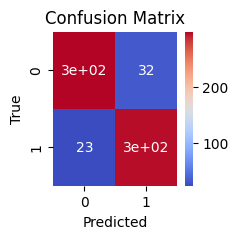

In [37]:
clf = SVC(kernel='rbf')

for i in range (len(test_name_list)):
    knn = KNeighborsClassifier()
    print("\033[1m" + "\033[36m" + "\033[14m" + test_name_list[i] + "\033[0m") #Printing the heading
    for j in (TEST_SIZES):
        X_train, X_test, y_train, y_test = train_test_split(X_reduced, Y[test_name_list[i]], test_size=j, random_state=42)
        X_train, y_train = balance_data(X_train, y_train)
        print(j)
        
        clf.fit(X_train, y_train)
        knn.fit(X_train, y_train)

        y_pred_svm = clf.predict(X_test)
        y_pred_knn = knn.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred_svm)
        precision = precision_score(y_test, y_pred_svm, average='weighted')
        recall = recall_score(y_test, y_pred_svm, average='weighted')

        print("SVM")
        print('Accuracy:', accuracy)
        print('Precision:', precision)
        print('Recall:', recall)

        cm = confusion_matrix(y_test, y_pred_svm)

        plt.figure(figsize=(2, 2))
        sns.heatmap(cm, annot=True, cmap='coolwarm')
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

        accuracy = accuracy_score(y_test, y_pred_knn)
        precision = precision_score(y_test, y_pred_knn, average='weighted')
        recall = recall_score(y_test, y_pred_knn, average='weighted')

        print("KNN")
        print('Accuracy:', accuracy)
        print('Precision:', precision)
        print('Recall:', recall)

        cm = confusion_matrix(y_test, y_pred_knn)

        plt.figure(figsize=(2,2))
        sns.heatmap(cm, annot=True, cmap='coolwarm')
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()


Keeping the `test_size` equal to a small value results in very high accuracy however it can lead to overfitting of model to the dataset provided to us. 

As a balance between preventing overfitting and training the model with sufficient data, I will choose `test_size = 0.15` as the final value

Hinselmann
(1064, 18) (1064,)
KNN
Accuracy: 0.8776978417266187
Precision: 0.8831344015696533
Recall: 0.8776978417266187


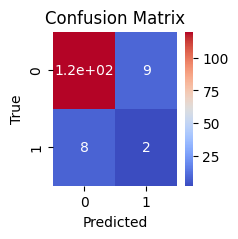

Schiller
(1020, 18) (1020,)
KNN
Accuracy: 0.8489208633093526
Precision: 0.8812103258569616
Recall: 0.8489208633093526


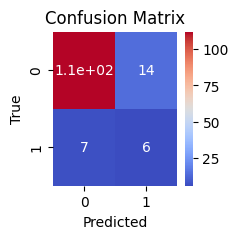

Citology
(1048, 18) (1048,)
KNN
Accuracy: 0.8992805755395683
Precision: 0.9411075790530365
Recall: 0.8992805755395683


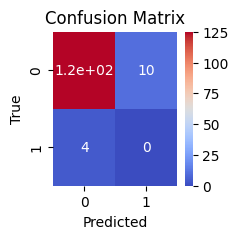

Biopsy
(1036, 18) (1036,)
KNN
Accuracy: 0.8489208633093526
Precision: 0.890119611627771
Recall: 0.8489208633093526


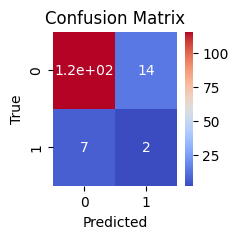

In [23]:
accuracy_list = []
precision_list = []
recall_list = []



for i in range (len(test_name_list)):
    clf = SVC(FINAL_PARAMETERS_SVM[i])
    knn = KNeighborsClassifier(n_neighbors = 2, metric = FINAL_PARAMETERS_KNN[i]['metric'], weights = FINAL_PARAMETERS_KNN[i]['weights'])
    print("\033[1m" + "\033[36m" + "\033[14m" + test_name_list[i] + "\033[0m") #Printing the heading
    X_train, X_test, y_train, y_test = train_test_split(X_reduced, Y[test_name_list[i]], test_size=FINAL_TEST_SIZE, random_state=42)
    X_train, y_train = balance_data(X_train, y_train)
    
    clf.fit(X_train, y_train)
    knn.fit(X_train, y_train)

    y_pred_svm = clf.predict(X_test)
    y_pred_knn = knn.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred_svm)
    precision = precision_score(y_test, y_pred_svm, average='weighted')
    recall = recall_score(y_test, y_pred_svm, average='weighted')

    print("SVM")
    print('Accuracy:', accuracy)
    print('Precision:', precision)
    print('Recall:', recall)
    # accuracy_list.append(accuracy)
    precision_list.append(precision)
    recall_list.append(recall)

    cm = confusion_matrix(y_test, y_pred_svm)

    plt.figure(figsize=(2, 2))
    sns.heatmap(cm, annot=True, cmap='coolwarm')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    accuracy = accuracy_score(y_test, y_pred_knn)
    precision = precision_score(y_test, y_pred_knn, average='weighted')
    recall = recall_score(y_test, y_pred_knn, average='weighted')
    accuracy_list.append(accuracy)
    precision_list.append(precision)
    recall_list.append(recall)

    print("KNN")
    print('Accuracy:', accuracy)
    print('Precision:', precision)
    print('Recall:', recall)

    cm = confusion_matrix(y_test, y_pred_knn)

    plt.figure(figsize=(2,2))
    sns.heatmap(cm, annot=True, cmap='coolwarm')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()


After training the entire model, I played around with the `N_COMPONENTS` value (the number of dimensions in the reduced dataset after using PCA). Preserving very high variance in the dataset was leading to slightly lower accuracy (perhaps due to overfitting of the model), while dropping it too low would drop the accuracy as the model couldn't capture the trends in the data.

In [39]:
# print(accuracy_list)
# print(precision_list)
# print(recall_list)

data = [accuracy_list, precision_list, recall_list]

# result = pd.DataFrame(data)
# print(result)

columns = pd.MultiIndex.from_product([['Hinselmann', 'Schiller', 'Cytology', 'Biopsy'],
                                      ['SVM', 'KNN']],
                                     names=['Target Variable', 'Classifier'])

result = pd.DataFrame(data, columns=columns, index=['Accuracy', 'Precision', 'Recall'])
print(result)

result.to_csv('model_results_cervical_cancer.csv')

Target Variable Hinselmann            Schiller            Cytology            \
Classifier             SVM       KNN       SVM       KNN       SVM       KNN   
Accuracy          0.830189  0.950943  0.756863  0.862745  0.806818  0.909091   
Precision         0.839120  0.954405  0.763688  0.870312  0.809324  0.912676   
Recall            0.830189  0.950943  0.756863  0.862745  0.806818  0.909091   

Target Variable    Biopsy            
Classifier            SVM       KNN  
Accuracy         0.750000  0.934615  
Precision        0.768116  0.935827  
Recall           0.750000  0.934615  
